In [1]:
import os
import torch
from d2l import torch as d2l

In [2]:
#@save
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

#@save
def read_data_nmt():
    """载入“英语－法语”数据集"""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r',
             encoding='utf-8') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [3]:
def preprocess_nmt(text):
    """预处理“英语－法语”数据集"""
    def no_space(char, prev_char):
        return char in set(',.!') and prev_char != ' '

    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace(
        '\xa0', ' ').lower()  # \u202f是不间断空格，\xa0是不间断空格
    # 在单词和标点符号之间插入空格
    out = [' '+char if i > 0 and no_space(char, text[i-1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])


go .	va !
hi .	salut !
run !	cours !
run !	courez !
who?	qui ?
wow !	ça alors !



In [4]:
def tokenize_nmt(text,num_examples=None):
    """词源化 英语-法语 数据集"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i>num_examples:
            break
        parts = line.split('\t')#以tab分割
        if len(parts)==2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source,target
source,target = tokenize_nmt(text)
source[:6],target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

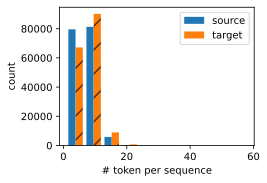

In [21]:
def show_list_len_pair_hist(legend,xlable,ylable,xlist,ylist):
    '''绘制链表长度直方图'''
    d2l.set_figsize()
    # d2l.plt.hist returns a tuple of (n, bins, patches)  pathces是一个列表，每个元素是一个矩形
    _,_,patches = d2l.plt.hist([[len(l) for l in xlist],[len(l) for l in ylist]])
    d2l.plt.xlabel(xlable)
    d2l.plt.ylabel(ylable)
    d2l.plt.legend(legend)
    #设置斜线
    for patch in patches[1].patches:
        patch.set_hatch('/')
    d2l.plt.show()
show_list_len_pair_hist(['source','target'],'# token per sequence','count',source,target)

In [5]:
src_vacab = d2l.Vocab(source,min_freq=2,reserved_tokens=['<pad>','<bos>','<eos>'])
len(src_vacab)

11724

In [6]:
def truncate_pad(line,num_steps,padding_token):
    '''截断或者填充序列'''
    if len(line)>num_steps:
        return line[:num_steps]
    return line + [padding_token]*(num_steps-len(line))
truncate_pad(src_vacab[source[0]],10,src_vacab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [6]:
#@save
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

In [7]:
#@save
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词表"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [9]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)


In [10]:
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('X的有效长度:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('Y的有效长度:', Y_valid_len)
    break

X: tensor([[135,  14,   4,   3,   1,   1,   1,   1],
        [ 65,  14,   4,   3,   1,   1,   1,   1]], dtype=torch.int32)
X的有效长度: tensor([4, 4])
Y: tensor([[  0,   5,   3,   1,   1,   1,   1,   1],
        [142,   5,   3,   1,   1,   1,   1,   1]], dtype=torch.int32)
Y的有效长度: tensor([3, 3])
